# Training Code for the Multi Agent Project

By: Daniel Nehren

Date: 7/13/2020

In [16]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import deque
import copy
import ptan

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

In [17]:
from maddpg_model import Config,Actor,Critic,ReplayBuffer,MADDPGAgent

In [3]:
env = UnityEnvironment(file_name='Tennis_Linux/Tennis.x86_64',no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
env_info = env.reset(train_mode=True)[brain_name]
n_agents = len(env_info.agents)
state_size = env_info.vector_observations.shape[1]
action_size = env_info.previous_vector_actions.shape[0]

In [6]:
config = Config()

writer = SummaryWriter(comment="-tennis_maddpg")

### Training Loop

In [8]:
config.ACTOR_FC1_UNITS = 265
config.ACTOR_FC2_UNITS = 128
config.CRITIC_FC1_UNITS = 256
config.CRITIC_FC2_UNITS = 128
config.LR_ACTOR = 1e-4
config.LR_CRITIC = 3e-4
config.TAU = 1e-3

#REPLAY BUFFER
config.BUFFER_SIZE = int(1e5)
config.BATCH_SIZE = 256
config.GAMMA = 0.99
config.WEIGHT_DECAY = 0
config.DEVICE = 'cpu'

config.WAIT_EPOCHS = 300
config.NOISE_START=1.0
config.NOISE_END=0.1
config.NOISE_REDUCTION=0.999

config.TRAINING_ITERATIONS_PER_STEP = 3

seed = 14
random.seed(seed)
np.random.seed(seed)
_ = torch.manual_seed(seed)


In [9]:
agents = [MADDPGAgent(state_size,action_size,n_agents,config) for _ in range(n_agents)]
replay_buffer = ReplayBuffer(config.BUFFER_SIZE,config.BATCH_SIZE,config.device)

In [10]:
NUM_EPOCHS=10000
MAX_STEPS = 300

with ptan.common.utils.TBMeanTracker(writer, batch_size=100) as tb_tracker:
    scores_deque = deque(maxlen=100)
    scores_list = []
    scores_list_100_avg = []
    
    noise_scale = config.NOISE_START
    
    for epoch in range(1, NUM_EPOCHS+1):
        
        if epoch > config.WAIT_EPOCHS and noise_scale > config.NOISE_END:                
            noise_scale = config.NOISE_REDUCTION**(epoch-config.WAIT_EPOCHS)
           
        env_info = env.reset(train_mode=True)[brain_name]                                
        scores = np.zeros(n_agents)                  
        
        num_steps = 0
        for _ in range(MAX_STEPS):
            
            states = env_info.vector_observations
            
            actions = np.asarray([agents[i].act(states[i],noise_scale=noise_scale) for i in range(len(agents))])
            
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations
            
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            
            full_states = np.reshape(states,(n_agents*state_size))
            full_next_states = np.reshape(next_states,(n_agents*state_size))
        
            replay_buffer.add(full_states, states, actions, rewards, full_next_states, next_states, dones)            
            scores += rewards                                  
            
            if len(replay_buffer) > config.BATCH_SIZE and epoch > config.WAIT_EPOCHS:
            
                for _ in range(config.TRAINING_ITERATIONS_PER_STEP): 
                
                    #Run training step one per agent
                    for agent_id in range(n_agents):

                        rb_full_states, rb_states, rb_actions, rb_rewards, rb_full_next_states, rb_next_states, rb_dones = replay_buffer.sample()
                        next_actions = [agents[i].actor_target.forward(rb_next_states[:,i,:]).detach().numpy() for i in range(n_agents)]
                        full_next_actions = torch.from_numpy(np.concatenate(next_actions,axis=1)).to(config.device)

                        agent = agents[agent_id]
                        agent_state = rb_states[:,agent_id,:]
                        agent_rewards = rb_rewards[:,agent_id].view(-1,1) 
                        agent_dones = rb_dones[:,agent_id].view(-1,1) 

                        actor_full_actions = rb_actions.clone()
                        actor_full_actions[:,agent_id,:] = agent.actor_local.forward(agent_state)
                        actor_full_actions = actor_full_actions.view(-1, n_agents*action_size)

                        full_actions = rb_actions.view(-1,n_agents*action_size)

                        experiences = (rb_full_states, actor_full_actions, full_actions, agent_rewards, agent_dones, rb_full_next_states, full_next_actions)
                        agent_losses = agent.learning_step(experiences, config.GAMMA)

                        agent.soft_update()

                        tb_tracker.track(f"loss_critic_{agent_id}", agent_losses[0], epoch)
                        tb_tracker.track(f"loss_actor_{agent_id}", agent_losses[1], epoch)                    
            
            num_steps += 1
            if np.any(dones):                                  
                break
            
        scores_deque.append(np.max(scores))
        scores_list.append(np.max(scores))
        scores_list_100_avg.append(np.mean(scores_deque))

        tb_tracker.track("num_steps", num_steps, epoch)
        tb_tracker.track("reward", np.max(scores), epoch)
        tb_tracker.track("reward_100", sum(scores_deque)/len(scores_deque), epoch)
                    
        if epoch % 50 == 0:
            print('Epoch {}\tAverage Score: {:.2f}\tCurrent Score: {}'.format(epoch, np.mean(scores_deque), np.max(scores)))
            print('Noise Scaling: {}, Memory size: {} and Num Steps: {}'.format(noise_scale, len(replay_buffer), num_steps))

        if np.mean(scores_deque) > 0.5 and len(scores_deque) >= 100:
            print("Solved!")
            break

Epoch 50	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 862 and Num Steps: 14
Epoch 100	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1808 and Num Steps: 15
Epoch 150	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2772 and Num Steps: 14
Epoch 200	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 3651 and Num Steps: 14
Epoch 250	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 4589 and Num Steps: 14
Epoch 300	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 5485 and Num Steps: 17
Epoch 350	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.9512056281970314, Memory size: 6195 and Num Steps: 14
Epoch 400	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.9047921471137089, Memory size: 7058 and Num Steps: 15
Epoch 450	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.8606433826830363, Memory size: 7831 and Num Steps: 15
Epoch 500	Av

### Save Parameters

In [11]:
learning_state = {
    'epoch': epoch,
    'score_list': scores_list,    
}

for i,agent in enumerate(agents):
    
    learning_state[f'actor_{i}'] = agent.actor_local.state_dict()
    learning_state[f'critic_{i}'] = agent.critic_local.state_dict()
    learning_state[f'actor_opt_{i}'] = agent.actor_optimizer.state_dict()
    learning_state[f'critic_opt_{i}'] = agent.critic_optimizer.state_dict()
    
torch.save(learning_state,'./solverd_state.ckp')
np.save('./score_list',scores_list)

### Training Results

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
score_list = np.load('./score_list.npy')

print(f'Last 100 Epochs Avg Score = {score_list[-100:].mean():2.3f}')

Last 100 Epochs Avg Score = 0.501


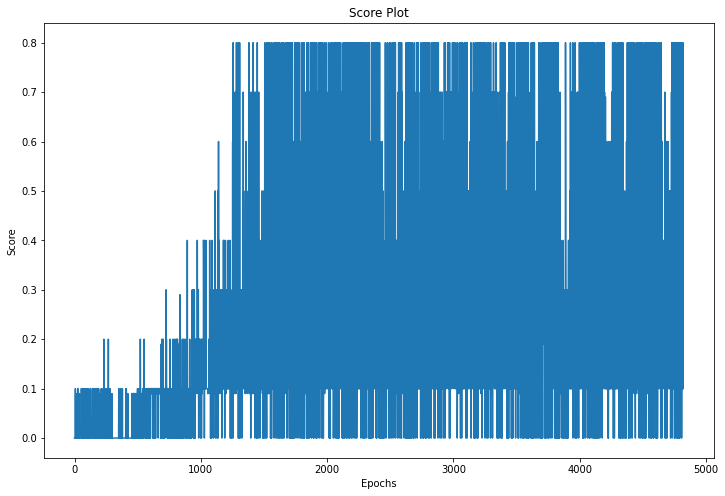

In [13]:
fig, ax = plt.subplots(figsize = (12,8))
_ = plt.plot(score_list)
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Score")
_ = plt.title("Score Plot")
plt.show()

In [14]:
data = torch.load('./solverd_state.ckp')
data

{'epoch': 4820,
 'score_list': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.10000000149011612,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.09000000171363354,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.09000000171363354,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.09000000171363354,
  0.09000000171363354,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.10000000149011612,
  0.09000000171363354,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.09000000171363354,
  0.0,
  0.0,
  0.10000000149011612,
  0.0,
  0.0,
  0.10000000149011612,
  0.10000000149011612,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.10000000149011612,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.09000000171363354,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.10000000149011612,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0